In [32]:
import torch
import numpy as np 
import matplotlib.pyplot as plt
import spatial_maps as sm
from scipy.integrate import cumtrapz

from tqdm import tqdm
from models import FFGC, RNNGC
from plotting_functions import *
from dataset import DatasetMaker

import pandas as pd
import seaborn as sns

import scipy

In [30]:
plt.style.use("project_style.mplstyle")

In [2]:
## Training parameters
train_steps = 50000
timesteps = 10
bs = 64 # batch size
ng = 256 # no. of recurrent units

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

array([0.01, 0.08, 0.15, 0.22, 0.29, 0.36, 0.43, 0.5 , 0.57, 0.64, 0.71,
       0.78, 0.85, 0.92, 0.99])

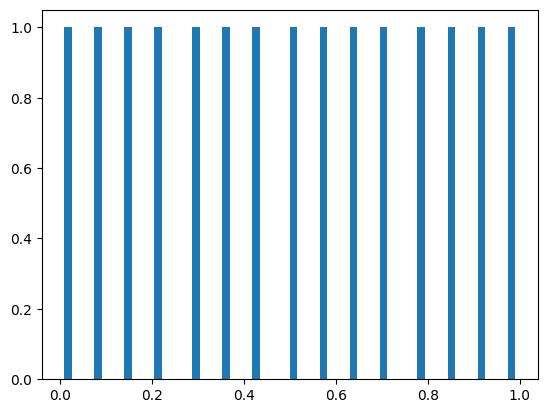

In [4]:
# Get even distribution from distribution function

def inverse_transform_sampling(prob_density_func, num_samples):
    # Create an array across the interval [0, 1]
    x = np.linspace(0.01, 0.99, 10000)

    # Calculate the cumulative distribution function (CDF)
    cdf = cumtrapz(prob_density_func(x), x)
    cdf = np.insert(cdf, 0, 0)

    # Use the CDF to get the inverse CDF
    inverse_cdf = np.interp(np.linspace(0, cdf[-1], num_samples), cdf, x)

    return inverse_cdf

# alphas = inverse_transform_sampling(lambda x: 1/(x*(1-x)), 100)
# alphas = inverse_transform_sampling(lambda x: (1-x)/x + x/(1-x), 32)
alphas = inverse_transform_sampling(lambda x: np.ones(len(x)), 15)
plt.hist(alphas, bins = 60)
alphas

In [5]:
# FF Grid search

# alphas = inverse_transform_sampling(lambda x: (1-x)/x + x/(1-x), 32)
# alphas = inverse_transform_sampling(lambda x: np.ones(len(x)), 11)
# sigmas = [0.4, 0.7, 1.0, 1.2, 1.5]
alphas = inverse_transform_sampling(lambda x: np.ones(len(x)), 15)
sigmas = [0.6, 0.8, 1.0, 1.2, 1.5]

# alphas = np.linspace(0.85, 0.94, 100)
# alphas = 1-np.geomspace(0.001,1,30)
grid_scores = np.zeros((len(sigmas), len(alphas), ng))
grid_spacings = np.zeros((len(sigmas), len(alphas)))
s_count = 0
for sigma in sigmas:
    a_count = 0
    for alpha in alphas:
        print(f'Alpha: {alpha}')
        print(f'Sigma: {sigma}')
        model = FFGC(alpha = alpha, sigma = sigma, norm = "l1")
        # model = RNNGC(ng = ng, alpha = alpha, norm = "l2")
        model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
        # Train model
        for i in tqdm(range(train_steps-len(model.total_loss_history))):
            r = torch.rand((bs, 2), device = device)*4*np.pi - 2*np.pi
            loss = model.train_step(inputs = r, labels = r, optimizer = optimizer)

        # Plot loss history
        # fig,axs = plt.subplots(1,3,figsize=(9,3))
        # axs[0].semilogy(np.array(model.total_loss_history)-model.loss_minima(), label = 'Total loss', color = 'black')
        # axs[1].semilogy(np.array(model.capacity_loss_history)-model.loss_minima(), label = 'Capacity loss', color = 'red')
        # axs[2].semilogy(model.similarity_loss_history, label = 'Similarity loss', color = 'blue')
        # fig.tight_layout()
        # fig.legend()
        # plt.savefig(f'./gridsearch/ffgc_loss_alpha_{alpha}.png')
        # plt.close()

        # evaluate on 64x64 grid
        res = 128
        x = np.linspace(-1, 1, res)*2*np.pi
        y = np.linspace(-1, 1, res)*2*np.pi
        xx, yy = np.meshgrid(x,y)
        r = np.stack([xx.ravel(), yy.ravel()], axis = -1)
        gs = model(torch.tensor(r.astype("float32"),device = device))
        gs = gs.detach().cpu().numpy()
        gs = gs.T.reshape(-1,res,res)

        # plot spatial map
        # multiimshow(gs[:25], figsize=(10,10), normalize=False);
        # plt.tight_layout()
        # plt.savefig(f'./gridsearch/ffgc_spatial_map_alpha_{alpha}.png')
        # plt.close()

        # Gridscore
        grid_score = np.array([sm.gridness(gs[i]) for i in range(len(gs))])
        grid_scores[np.isnan(grid_scores)] = 0
        grid_scores[s_count, a_count] = grid_score

        acorrs = np.array([sm.autocorrelation(g) for g in gs])
        acorrs = acorrs[grid_score > 0.5]
        gs = gs[grid_score > 0.5]
        peaks = [sm.find_peaks(acorr) for acorr in acorrs]
        spacings = np.array([sm.spacing_and_orientation(peak, acorrs.shape[-1])[0] for peak in peaks])
        # Ignore nans in spacings
        spacings = spacings[~np.isnan(spacings)]
        grid_spacings[s_count, a_count] = np.mean(spacings)

        a_count += 1
    s_count += 1

# Save grid scores
np.save('./gridsearch/ffgc_grid_scores.npy', grid_scores)
np.save('./gridsearch/ffgc_grid_spacings.npy', grid_spacings)
np.save('./gridsearch/ffgc_grid_search_alphas.npy', alphas)
np.save('./gridsearch/ffgc_grid_search_sigmas.npy', sigmas)

Alpha: 0.01
Sigma: 0.4


c:\Users\kingt\anaconda3\envs\torch2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 50000/50000 [01:10<00:00, 710.08it/s]
c:\Users\kingt\anaconda3\envs\torch2\lib\site-packages\spatial_maps\tools.py:41: RuntimeWarning: invalid value encountered in true_divide
  arr1 = (arr1 - np.mean(a_)) / (np.std(a_) * len(a_))
c:\Users\kingt\anaconda3\envs\torch2\lib\site-packages\spatial_maps\tools.py:42: RuntimeWarning: invalid value encountered in true_divide
  arr2 = (arr2 - np.mean(v_)) / np.std(v_)
c:\Users\kingt\anaconda3\envs\torch2\lib\site-packages\numpy\core\fromnumeric.py:86: UserWarning: Warning: converting a masked element to nan.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\kingt\anaconda3\envs\torch2\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean o

Alpha: 0.08
Sigma: 0.4


100%|██████████| 50000/50000 [01:09<00:00, 719.73it/s]


Alpha: 0.15
Sigma: 0.4


100%|██████████| 50000/50000 [01:08<00:00, 725.84it/s]


Alpha: 0.21999999999999997
Sigma: 0.4


100%|██████████| 50000/50000 [01:08<00:00, 727.53it/s]


Alpha: 0.29
Sigma: 0.4


100%|██████████| 50000/50000 [01:10<00:00, 709.04it/s]


Alpha: 0.36
Sigma: 0.4


100%|██████████| 50000/50000 [01:08<00:00, 728.66it/s]


Alpha: 0.42999999999999994
Sigma: 0.4


100%|██████████| 50000/50000 [01:08<00:00, 725.34it/s]


Alpha: 0.49999999999999994
Sigma: 0.4


100%|██████████| 50000/50000 [01:08<00:00, 726.88it/s]


Alpha: 0.57
Sigma: 0.4


100%|██████████| 50000/50000 [01:08<00:00, 727.09it/s]


Alpha: 0.6399999999999999
Sigma: 0.4


100%|██████████| 50000/50000 [01:09<00:00, 723.14it/s]


Alpha: 0.71
Sigma: 0.4


100%|██████████| 50000/50000 [01:08<00:00, 728.20it/s]


Alpha: 0.7799999999999999
Sigma: 0.4


100%|██████████| 50000/50000 [01:08<00:00, 725.91it/s]


Alpha: 0.8499999999999999
Sigma: 0.4


100%|██████████| 50000/50000 [01:08<00:00, 732.57it/s]


Alpha: 0.9199999999999999
Sigma: 0.4


100%|██████████| 50000/50000 [01:08<00:00, 729.59it/s]


Alpha: 0.99
Sigma: 0.4


100%|██████████| 50000/50000 [01:08<00:00, 726.90it/s]


Alpha: 0.01
Sigma: 0.7


100%|██████████| 50000/50000 [01:08<00:00, 728.68it/s]


Alpha: 0.08
Sigma: 0.7


100%|██████████| 50000/50000 [01:09<00:00, 723.98it/s]


Alpha: 0.15
Sigma: 0.7


100%|██████████| 50000/50000 [01:08<00:00, 726.24it/s]


Alpha: 0.21999999999999997
Sigma: 0.7


100%|██████████| 50000/50000 [01:08<00:00, 725.75it/s]


Alpha: 0.29
Sigma: 0.7


100%|██████████| 50000/50000 [01:11<00:00, 698.39it/s]


Alpha: 0.36
Sigma: 0.7


100%|██████████| 50000/50000 [01:09<00:00, 722.85it/s]


Alpha: 0.42999999999999994
Sigma: 0.7


100%|██████████| 50000/50000 [01:09<00:00, 724.45it/s]


Alpha: 0.49999999999999994
Sigma: 0.7


100%|██████████| 50000/50000 [01:09<00:00, 724.05it/s]


Alpha: 0.57
Sigma: 0.7


100%|██████████| 50000/50000 [01:08<00:00, 726.31it/s]


Alpha: 0.6399999999999999
Sigma: 0.7


100%|██████████| 50000/50000 [01:09<00:00, 723.40it/s]


Alpha: 0.71
Sigma: 0.7


100%|██████████| 50000/50000 [01:08<00:00, 726.99it/s]


Alpha: 0.7799999999999999
Sigma: 0.7


100%|██████████| 50000/50000 [01:09<00:00, 721.72it/s]


Alpha: 0.8499999999999999
Sigma: 0.7


100%|██████████| 50000/50000 [01:08<00:00, 727.45it/s]


Alpha: 0.9199999999999999
Sigma: 0.7


100%|██████████| 50000/50000 [01:08<00:00, 725.31it/s]


Alpha: 0.99
Sigma: 0.7


100%|██████████| 50000/50000 [01:08<00:00, 733.04it/s]


Alpha: 0.01
Sigma: 1.0


100%|██████████| 50000/50000 [01:08<00:00, 730.71it/s]


Alpha: 0.08
Sigma: 1.0


100%|██████████| 50000/50000 [01:08<00:00, 726.28it/s]


Alpha: 0.15
Sigma: 1.0


100%|██████████| 50000/50000 [01:08<00:00, 731.44it/s]


Alpha: 0.21999999999999997
Sigma: 1.0


100%|██████████| 50000/50000 [01:08<00:00, 727.81it/s]


Alpha: 0.29
Sigma: 1.0


100%|██████████| 50000/50000 [01:08<00:00, 733.17it/s]


Alpha: 0.36
Sigma: 1.0


100%|██████████| 50000/50000 [01:08<00:00, 727.36it/s]


Alpha: 0.42999999999999994
Sigma: 1.0


100%|██████████| 50000/50000 [01:08<00:00, 726.37it/s]


Alpha: 0.49999999999999994
Sigma: 1.0


100%|██████████| 50000/50000 [01:08<00:00, 724.79it/s]


Alpha: 0.57
Sigma: 1.0


100%|██████████| 50000/50000 [01:09<00:00, 720.42it/s]


Alpha: 0.6399999999999999
Sigma: 1.0


100%|██████████| 50000/50000 [01:07<00:00, 736.57it/s]


Alpha: 0.71
Sigma: 1.0


100%|██████████| 50000/50000 [01:08<00:00, 731.30it/s]


Alpha: 0.7799999999999999
Sigma: 1.0


100%|██████████| 50000/50000 [01:07<00:00, 737.96it/s]


Alpha: 0.8499999999999999
Sigma: 1.0


100%|██████████| 50000/50000 [01:08<00:00, 732.00it/s]


Alpha: 0.9199999999999999
Sigma: 1.0


100%|██████████| 50000/50000 [01:08<00:00, 732.85it/s]


Alpha: 0.99
Sigma: 1.0


100%|██████████| 50000/50000 [01:08<00:00, 732.79it/s]


Alpha: 0.01
Sigma: 1.2


100%|██████████| 50000/50000 [01:08<00:00, 734.44it/s]


Alpha: 0.08
Sigma: 1.2


100%|██████████| 50000/50000 [01:07<00:00, 738.75it/s]


Alpha: 0.15
Sigma: 1.2


100%|██████████| 50000/50000 [01:07<00:00, 735.40it/s]


Alpha: 0.21999999999999997
Sigma: 1.2


100%|██████████| 50000/50000 [01:07<00:00, 736.56it/s]


Alpha: 0.29
Sigma: 1.2


100%|██████████| 50000/50000 [01:08<00:00, 733.67it/s]


Alpha: 0.36
Sigma: 1.2


100%|██████████| 50000/50000 [01:08<00:00, 734.55it/s]


Alpha: 0.42999999999999994
Sigma: 1.2


100%|██████████| 50000/50000 [01:07<00:00, 738.51it/s]


Alpha: 0.49999999999999994
Sigma: 1.2


100%|██████████| 50000/50000 [01:08<00:00, 734.05it/s]


Alpha: 0.57
Sigma: 1.2


100%|██████████| 50000/50000 [01:07<00:00, 735.57it/s]


Alpha: 0.6399999999999999
Sigma: 1.2


100%|██████████| 50000/50000 [01:08<00:00, 730.41it/s]


Alpha: 0.71
Sigma: 1.2


100%|██████████| 50000/50000 [01:07<00:00, 738.16it/s]


Alpha: 0.7799999999999999
Sigma: 1.2


100%|██████████| 50000/50000 [01:08<00:00, 730.92it/s]


Alpha: 0.8499999999999999
Sigma: 1.2


100%|██████████| 50000/50000 [01:07<00:00, 736.71it/s]


Alpha: 0.9199999999999999
Sigma: 1.2


100%|██████████| 50000/50000 [01:08<00:00, 729.50it/s]


Alpha: 0.99
Sigma: 1.2


100%|██████████| 50000/50000 [01:08<00:00, 734.90it/s]


Alpha: 0.01
Sigma: 1.5


100%|██████████| 50000/50000 [01:07<00:00, 736.92it/s]


Alpha: 0.08
Sigma: 1.5


100%|██████████| 50000/50000 [01:08<00:00, 733.15it/s]


Alpha: 0.15
Sigma: 1.5


100%|██████████| 50000/50000 [01:07<00:00, 740.77it/s]


Alpha: 0.21999999999999997
Sigma: 1.5


100%|██████████| 50000/50000 [01:08<00:00, 733.00it/s]


Alpha: 0.29
Sigma: 1.5


100%|██████████| 50000/50000 [01:07<00:00, 739.30it/s]


Alpha: 0.36
Sigma: 1.5


100%|██████████| 50000/50000 [01:08<00:00, 732.42it/s]


Alpha: 0.42999999999999994
Sigma: 1.5


100%|██████████| 50000/50000 [01:07<00:00, 739.69it/s]


Alpha: 0.49999999999999994
Sigma: 1.5


100%|██████████| 50000/50000 [01:07<00:00, 738.02it/s]


Alpha: 0.57
Sigma: 1.5


100%|██████████| 50000/50000 [01:07<00:00, 738.84it/s]


Alpha: 0.6399999999999999
Sigma: 1.5


100%|██████████| 50000/50000 [01:07<00:00, 742.00it/s]


Alpha: 0.71
Sigma: 1.5


100%|██████████| 50000/50000 [01:08<00:00, 732.02it/s]


Alpha: 0.7799999999999999
Sigma: 1.5


100%|██████████| 50000/50000 [01:07<00:00, 737.70it/s]


Alpha: 0.8499999999999999
Sigma: 1.5


100%|██████████| 50000/50000 [01:08<00:00, 733.07it/s]


Alpha: 0.9199999999999999
Sigma: 1.5


100%|██████████| 50000/50000 [01:07<00:00, 736.93it/s]


Alpha: 0.99
Sigma: 1.5


100%|██████████| 50000/50000 [01:08<00:00, 730.97it/s]


In [7]:
# RNN Gridsearch

alphas = inverse_transform_sampling(lambda x: (1-x)/x + x/(1-x), 3)

dataset = DatasetMaker()

for norm in ["l1", "l2"]:
    grid_scores = []
    for alpha in alphas:
        print(f'Alpha: {alpha}')
        model = RNNGC(ng = ng, alpha = alpha, norm = norm)
        model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
        # Train model
        for i in tqdm(range(train_steps-len(model.total_loss_history))):
            r, v = dataset.generate_data(bs, timesteps, device)
            loss = model.train_step(inputs = (r[:,0], v), labels = r, optimizer = optimizer)

        # evaluate on 64x64 grid
        r, v = dataset.generate_data(20000, timesteps, device)
        g = model((r[:,0], v))

        r = r.detach().cpu().numpy()
        g = g.detach().cpu().numpy()
        ratemaps = scipy.stats.binned_statistic_2d(r[...,0].ravel(), r[...,1].ravel(), g.reshape(-1, g.shape[-1]).T, bins = 64)[0]

        # Gridscore
        grid_score = np.array([sm.gridness(ratemaps[i]) for i in range(len(ratemaps))])
        grid_scores.append(grid_score)

        model.save(path=f"./saved-models/{model.__class__.__name__}_{alpha}_{norm}.pkl")

    # Save grid scores
    grid_scores = np.array(grid_scores)
    np.save(f'./gridsearch/rnngc_grid_scores_{norm}.npy', grid_scores)
    np.save(f'./gridsearch/rnnc_grid_scores_alphas_{norm}.npy', alphas)

Alpha: 0.001


  6%|▌         | 3/50 [00:00<00:01, 27.47it/s]

100%|██████████| 50/50 [00:01<00:00, 30.74it/s]


Alpha: 0.5000000000000029


100%|██████████| 50/50 [00:01<00:00, 30.86it/s]


Alpha: 0.999


100%|██████████| 50/50 [00:01<00:00, 31.56it/s]


Alpha: 0.001


100%|██████████| 50/50 [00:01<00:00, 31.32it/s]


Alpha: 0.5000000000000029


100%|██████████| 50/50 [00:01<00:00, 31.27it/s]


Alpha: 0.999


100%|██████████| 50/50 [00:01<00:00, 31.97it/s]


In [20]:
np.load('./gridsearch/ffgc_grid_spacings.npy')[4]
# np.load('./gridsearch/ffgc_grid_search_sigmas.npy')

array([59.12930838, 66.58780146, 71.73474137, 53.17970797,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan])

(5,)

(15,)


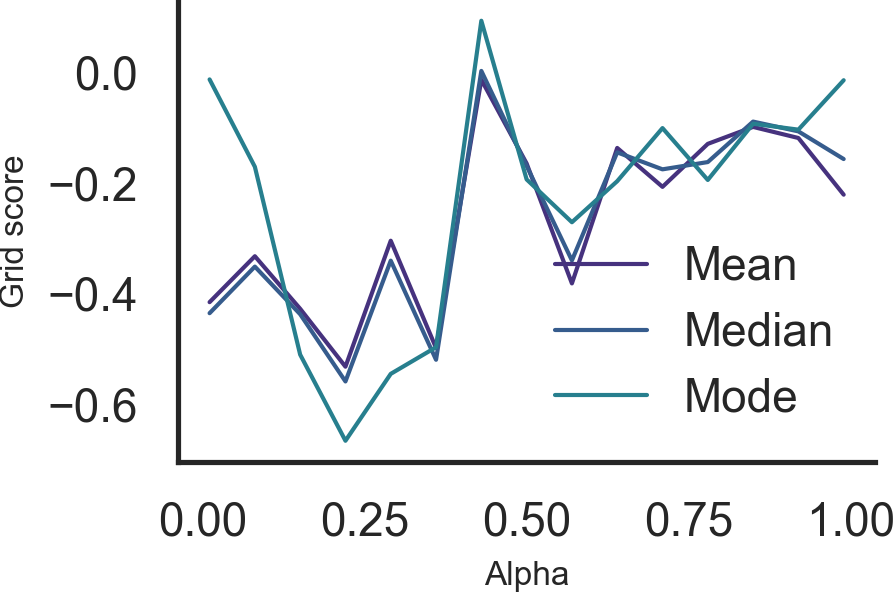

In [257]:
# NaNs to zeors

grid_scores = np.load('./gridsearch/ffgc_grid_scores.npy')
grid_spacings = np.load('./gridsearch/ffgc_grid_spacings.npy')
alphas = np.load('./gridsearch/ffgc_grid_search_alphas.npy')
sigmas = np.load('./gridsearch/ffgc_grid_search_sigmas.npy')

grid_scores[np.isnan(grid_scores)] = 0
grid_scores_binned = []



gs_means = np.mean(grid_scores, axis = 2)
gs_meadians = np.median(grid_scores, axis = 2)


# mode on 30 bins
i_plot = 0

grid_scores_i = grid_scores[i_plot]

gs_modes = np.zeros(len(grid_scores_i))

for i in range(len(grid_scores_i)):
    grid_scores_binned.append(np.histogram(grid_scores_i[i], bins = 100))
    gs_modes[i] = grid_scores_binned[i][1][np.argmax(grid_scores_binned[i][0])]


print(gs_modes.shape)

plt.figure(figsize=(3,2))
plt.plot(alphas, gs_means[i_plot], label = 'Mean')
plt.plot(alphas, gs_meadians[i_plot], label = 'Median')
plt.plot(alphas, gs_modes, label = 'Mode')
plt.xlabel('Alpha')
plt.ylabel('Grid score')
plt.legend()
# plt.savefig('./gridsearch/ffgc_grid_scores.png')
plt.show()

In [268]:
np.argmax(gs_means, axis = 1)

array([6, 9, 4, 3, 2], dtype=int64)

In [267]:
grid_spacings.shaape

(15,)

In [272]:
mode_max = alphas[np.argmax(gs_modes)]
mean_max = alphas[np.argmax(gs_means, axis = 1)]
median_max = alphas[np.argmax(gs_meadians, axis = 1)]
print(f'Mode alpha max: {mode_max}')
print(f'Mean alpha max: {mean_max}')
print(f'Median alpha max: {median_max}')

gridscales_at_best = []
for i in range(len(sigmas)):
    # Gridscale at max mean gridscore
    g_scale_best = grid_spacings[i][np.argmax(gs_means, axis = 1)[i]]
    gridscales_at_best.append(g_scale_best)

gridscales_at_best

Mode alpha max: 0.42999999999999994
Mean alpha max: [0.43 0.64 0.29 0.22 0.15]
Median alpha max: [0.43 0.64 0.36 0.22 0.15]


[20.3480466814482,
 41.274423490817,
 50.971076800387095,
 59.280892607529466,
 71.7347413656662]

Text(-0.1, 2.5, 'Gridscore')

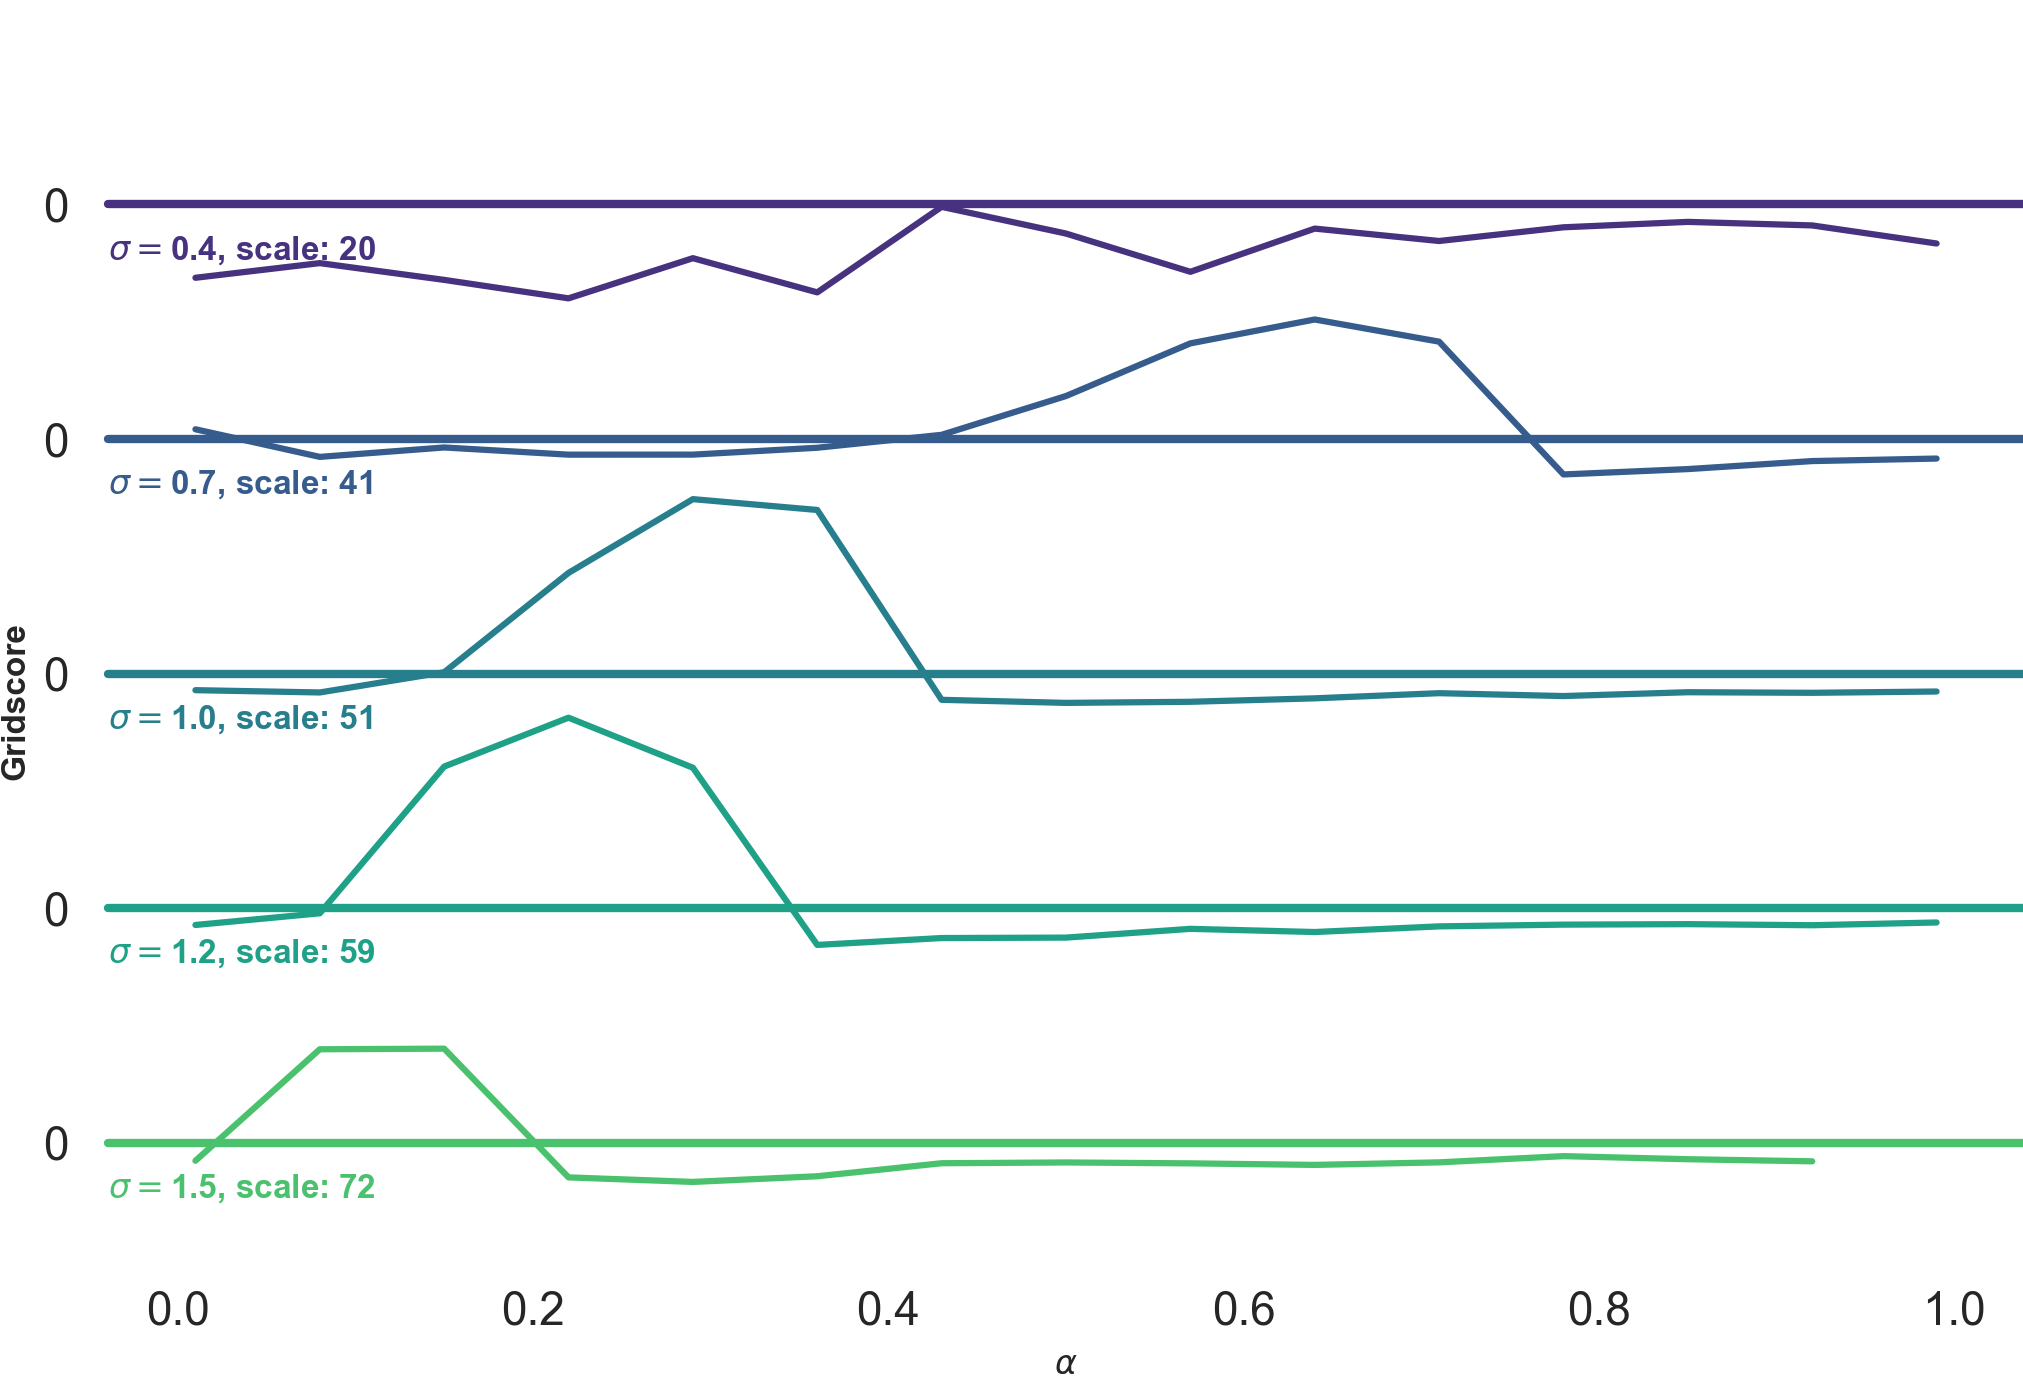

In [300]:
# Create the data

grid_scores = np.load('./gridsearch/ffgc_grid_scores.npy')
grid_spacings = np.load('./gridsearch/ffgc_grid_spacings.npy')
alphas = np.load('./gridsearch/ffgc_grid_search_alphas.npy')
sigmas = np.load('./gridsearch/ffgc_grid_search_sigmas.npy')

grid_scores_means = np.mean(grid_scores, axis = 2)

n_plots = len(sigmas)

# x = rs.randn(500)
x = grid_scores_means.T.flatten()
g = np.tile([r"$\sigma = $" + str(sigmas[i]) + ", scale: " + str(f"{gridscales_at_best[i]:.0f}") for i in range(len(sigmas))], len(alphas))
alphas_plot = np.repeat(alphas, len(sigmas))
df = pd.DataFrame(dict(x=x, g=g, alpha=alphas_plot))




# Initialize the FacetGrid object
g = sns.FacetGrid(df, row="g", hue="g", aspect=7, height=1)

# Draw the densities in a few steps

# Colored plot
# g.map_dataframe(sns.kdeplot, "x",
#       bw_adjust=.5, clip_on=False,
#       fill=True, alpha=1, linewidth=1.5)

# Plot 
g.map(sns.lineplot, "alpha", "x", alpha=1, linewidth=1.5, err_kws={'alpha':0})

# Create coloured axes
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    # label = r"\sigma" + f"{label:.2f}"
    ax.text(0, 0.2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[0], ylabel="", xlabel=r"$\alpha$")
g.despine(bottom=True, left=True)
ax = plt.gca()
ax.text(-0.1, 2.5, 'Gridscore', va='center', rotation='vertical', fontweight='bold')